# This notebook examines general trends in FAC data
A more thorough writeup can be found in https://drive.google.com/open?id=1U6stzP7qhqB3B10kNYnWdlgtAibwoFEI6cuKOSSq-ZU

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')
# print('General DF\n', df_general.head())

# Agency prefix dictionary:
with open(processed_path + 'agency_dict', 'rb') as f_w:
    agency_dict = pickle.load(f_w)
# Entity code dictionary:
with open(processed_path + 'entity_dict', 'rb') as f_w:
    entity_dict = pickle.load(f_w)

## Plot percent of all audits by entity type

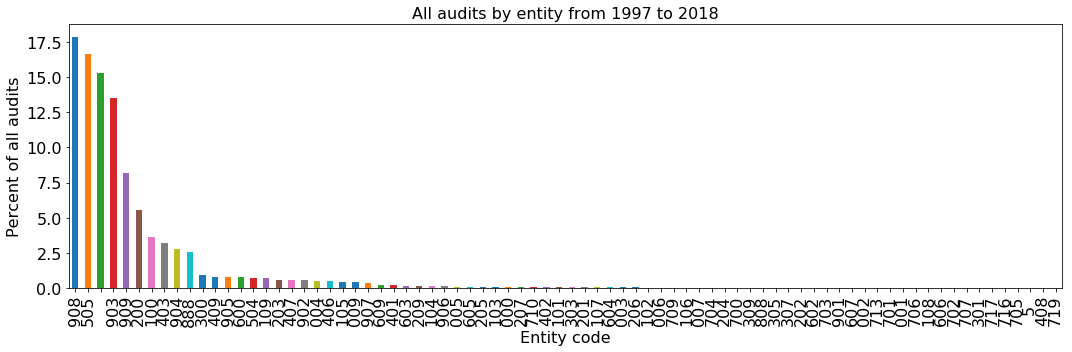

Total number of audits: 838217


In [2]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = df_general.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('Entity code', fontsize=16)
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16)
percent_audits_plot.set_title(
    'All audits by entity from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

## Plot percent of all audits by state

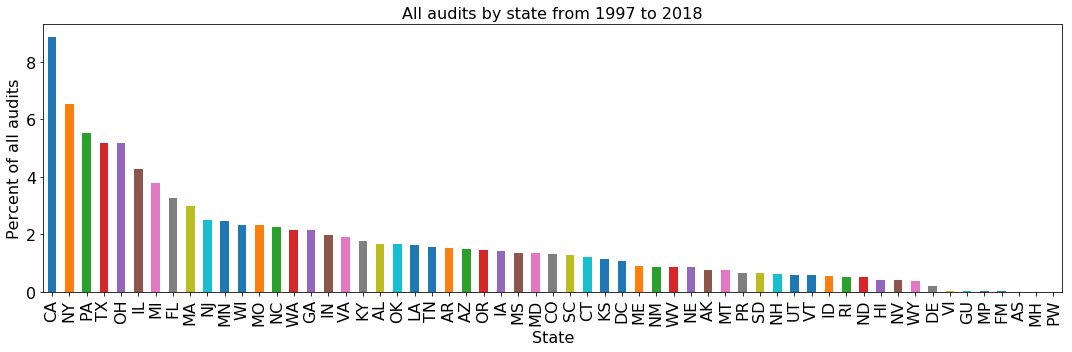

Total number of audits: 838217


In [3]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = df_general.groupby('STATE').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('State', fontsize=16)
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16)
percent_audits_plot.set_title(
    'All audits by state from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

## Findings for selected fields
Can select particular year, or set year = None in order to get aggregate statistics. Each plot is sorted by the total number of audits, decreasing from left to right.
* Financial Statements (TYPEREPORT_FS) and Major Program Compliance (TYPEREPORT_MP): opinion = U, Q, A or D, but focus on Q, A and D since the U's are majority and the other fields are super minorities
* Questioned Costs (QCOSTS), Reportable Condition (REPORTABLECONDITION, REPORTABLECONDITION_MP), Material Noncompliance (MATERIALNONCOMPLIANCE), and Material Weakness (MATERIALWEAKNESS, MATERIALWEAKNESS_MP): finding = primarily Y or N

Possible field types:
TYPEREPORT_MP: , A, 3, QAD, QA, U, QD, Q., D, Q, DQ, AD
REPORTABLECONDITION_MP: N, Y
MATERIALWEAKNESS_MP: , N, Y


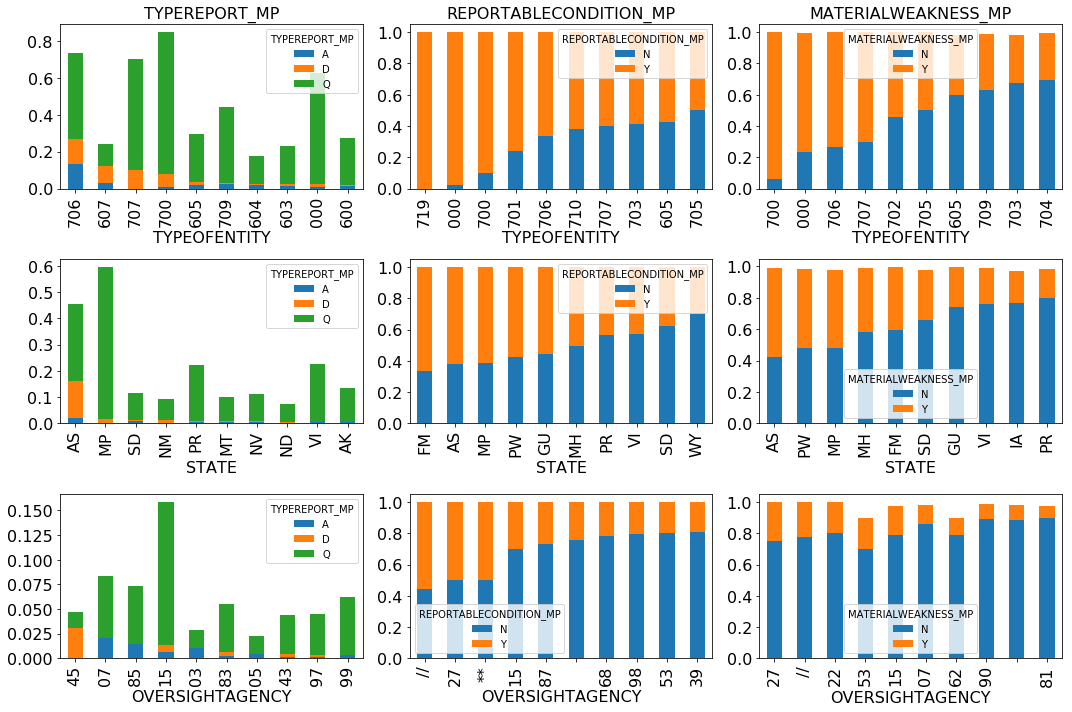

In [145]:
top_criterion = 'bad_findings'
year = None
sortbys = ['TYPEOFENTITY', 'STATE', 'OVERSIGHTAGENCY']
# fields = ['TYPEREPORT_FS', 'QCOSTS', 'MATERIALWEAKNESS', 'MATERIALNONCOMPLIANCE']
fields = ['TYPEREPORT_MP', 'REPORTABLECONDITION_MP', 'MATERIALWEAKNESS_MP']

if year:
    df_year = df_general[df_general['AUDITYEAR'] == year]
else:
    df_year = df_general
print('Possible field types:')
for field in fields:
    print('%s: %s' %(field, ', '.join(set(df_year[field]))))
fig, axes = plt.subplots(nrows=len(sortbys), ncols=len(fields), figsize=(len(fields)*5, 10))
for (i, sortby) in enumerate(sortbys):
    for (j, field) in enumerate(fields):
        series_grouped = df_year.groupby(sortby)[field].value_counts()
        df_grouped = series_grouped.unstack()
        df_grouped_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)
        if 'TYPEREPORT' in field:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['Q', 'A', 'D']]
            ]
        else:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['Y', 'N', 'X']]
            ]
        if top_criterion == 'total':  # Sort by total number of audits in df_year
            top_sortby = df_year[sortby].value_counts().head(10).index
        elif top_criterion == 'bad_findings':  # Sort by particularly bad findings in df_year
            if 'TYPEREPORT' in field:
                top_sortby = df_select_fields[['A', 'D']].sum(axis=1).sort_values(ascending=False).head(10).index
            else:
                top_sortby = df_select_fields['Y'].sort_values(ascending=False).head(10).index
        df_grouped_sorted = df_select_fields.reindex(index=top_sortby)
        plot_top_sorted = df_grouped_sorted.plot(
            kind='bar', fontsize=16, stacked=True, ax=axes[i, j]
        )
        if i == 0:
            plot_top_sorted.set_title(field, fontsize=16)
        plot_top_sorted.set_xlabel(sortby, fontsize=16)
plt.tight_layout()
plt.show()

In [147]:
len(df_year[(df_year['STATE']=='MP') & (df_year['TYPEREPORT_MP']=='D')])

3

In [132]:
df_general[df_general['STATE']=='VI']

,DBKEY,AUDITYEAR,STATE,CPASTATE,CPAPHONE,TYPEOFENTITY,OVERSIGHTAGENCY,TOTFEDEXPEND,AUDITEENAME,CPAFIRMNAME,...,TYPEREPORT_MP,REPORTABLECONDITION,MATERIALWEAKNESS,MATERIALNONCOMPLIANCE,REPORTABLECONDITION_MP,MATERIALWEAKNESS_MP,QCOSTS,CITY,CPACITY,EIN
273532,175867,2016,VI,ME,2079294606,505,84,912370,WINDSOR NORTHWEST SUPERVISORY UNION,RHR SMITH COMPANY,...,U,N,N,N,N,N,N,ROYALTON,BUXTON,30216998
291780,180265,1998,VI,PR,7877566020,,,181728223,GOVERNMENT OF UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,,Y,Y,N,Y,Y,Y,CHARLOTTE AMALIE,SAN JUAN,660431678
291781,180265,1999,VI,PR,7877566020,,,163268956,GOVERNMENT OF UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,Q,Y,Y,N,Y,Y,Y,CHARLOTTE AMALIE,SAN JUAN,660431678
291782,180265,2000,VI,PR,7877566020,,,157468193,GOVERNMENT OF UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,U,Y,Y,N,Y,Y,Y,CHARLOTTE AMALIE,SAN JUAN,660431678
291783,180265,2001,VI,PR,7877566020,700,,154646212,GOVERNMENT OF UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,Q,Y,Y,Y,Y,Y,Y,CHARLOTTE AMALIE ST. THOMAS,SAN JUAN,660431678
291784,180265,2002,VI,PR,7877566020,700,,177387560,THE GOVERNMENT OF UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,QA,Y,Y,Y,Y,Y,Y,CHARLOTTE AMALIE,SAN JUAN,660431678
291785,180265,2003,VI,PR,7877566020,700,,187643698,GOVERNMENT OF THE UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,QA,Y,Y,Y,Y,Y,Y,CHARLOTTE AMALIE ST. THOMAS,HATO REY,660431678
291786,180265,2004,VI,PR,7877566020,700,,158444729,GOVERNMENT OF THE UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,QA,Y,Y,Y,Y,Y,Y,CHARLOTTE AMALIE ST. THOMAS,HATO REY,660431678
291787,180265,2005,VI,PR,7876226471,700,,171815842,GOVERNMENT OF THE UNITED STATES VIRGIN ISLANDS,KPMG LLP,...,QA,Y,Y,Y,Y,Y,Y,CHARLOTTE AMALIE ST. THOMAS,HATO REY,660431678
291788,180265,2006,VI,PR,7877598212,700,,148186789,GOVERNMENT OF THE US VIRGIN ISLANDS,ERNST YOUNG LLP,...,QA,Y,Y,Y,Y,Y,Y,ST THOMAS,SAN JUAN,660431678


In [123]:
agency_dict['15']

'Department of the Interior'

In [130]:
entity_dict['904']

'Non-profit Institution for Higher Education'